# MLP Comparison Doc
------------------------------------------------------


Goal: setup a test bench to easily reconfigure MLP parameters

### Imports:

In [73]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

### Datasets:

In [95]:
from torchvision import datasets, transforms

img_res = (28, 28)  # SET RESOLUTION

resize_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                transforms.Resize(img_res)
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=resize_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=resize_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

1


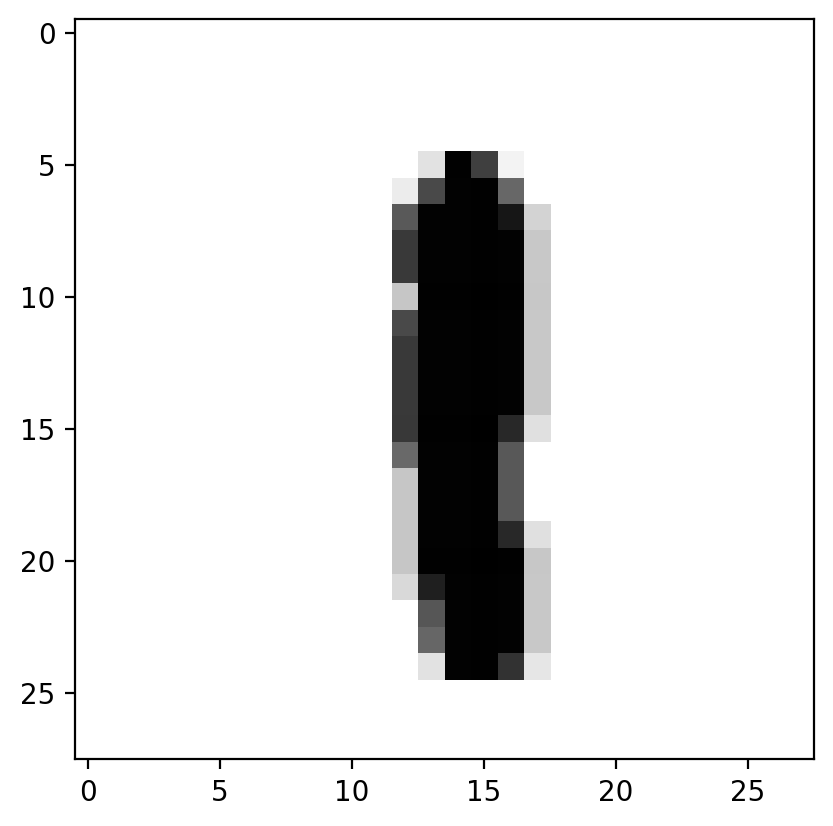

In [96]:
### Check images

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)
plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())

### MLP:

In [76]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001): # nlabels = 10 for digit classification
        super().__init__()

        # MODEL ARCHITECTURE:
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Other params
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training
        self.loss_during_training = []

    ### INFERENCE ###
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) #logsoftmax: probabilities for each of the ten outputs
        return x

    ### TRAINING ###
    def train(self,trainloader):
    
            # Optimization Loop
            for e in range(int(self.epochs)):
    
                # Random data permutation at each epoch
                running_loss = 0.
    
                for images, labels in trainloader:             
    
                    self.optim.zero_grad()  #TO RESET GRADIENTS!
    
                    out = self.forward(images.view(images.shape[0], -1))
    
                    # Compute loss
                    loss = self.criterion(out,labels)
    
                    running_loss += loss.item()
    
                    # Compute gradients (back propagation)
                    loss.backward()
    
                    # Update weights
                    self.optim.step()
    
    
                self.loss_during_training.append(running_loss/len(trainloader))
    
                if(e % 1 == 0): # Every 10 epochs
    
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    ### COMPUTE ACCURACY ###
    def eval_performance(self,dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

Training loss after 0 epochs: 0.272012
Training loss after 1 epochs: 0.128916
Training loss after 2 epochs: 0.099810
Training loss after 3 epochs: 0.081967
Training loss after 4 epochs: 0.068083
Training loss after 5 epochs: 0.060012
Training loss after 6 epochs: 0.052302
Training loss after 7 epochs: 0.049721
Training loss after 8 epochs: 0.043003
Training loss after 9 epochs: 0.037971
Training loss after 10 epochs: 0.035655
Training loss after 11 epochs: 0.031636
Training loss after 12 epochs: 0.032747
Training loss after 13 epochs: 0.028993
Training loss after 14 epochs: 0.027895
Training loss after 15 epochs: 0.030147
Training loss after 16 epochs: 0.027684
Training loss after 17 epochs: 0.023538
Training loss after 18 epochs: 0.026029
Training loss after 19 epochs: 0.021503
Train Accuracy 0.993903
Test Accuracy 0.978901


Text(0.5, 0, 'Epoch')

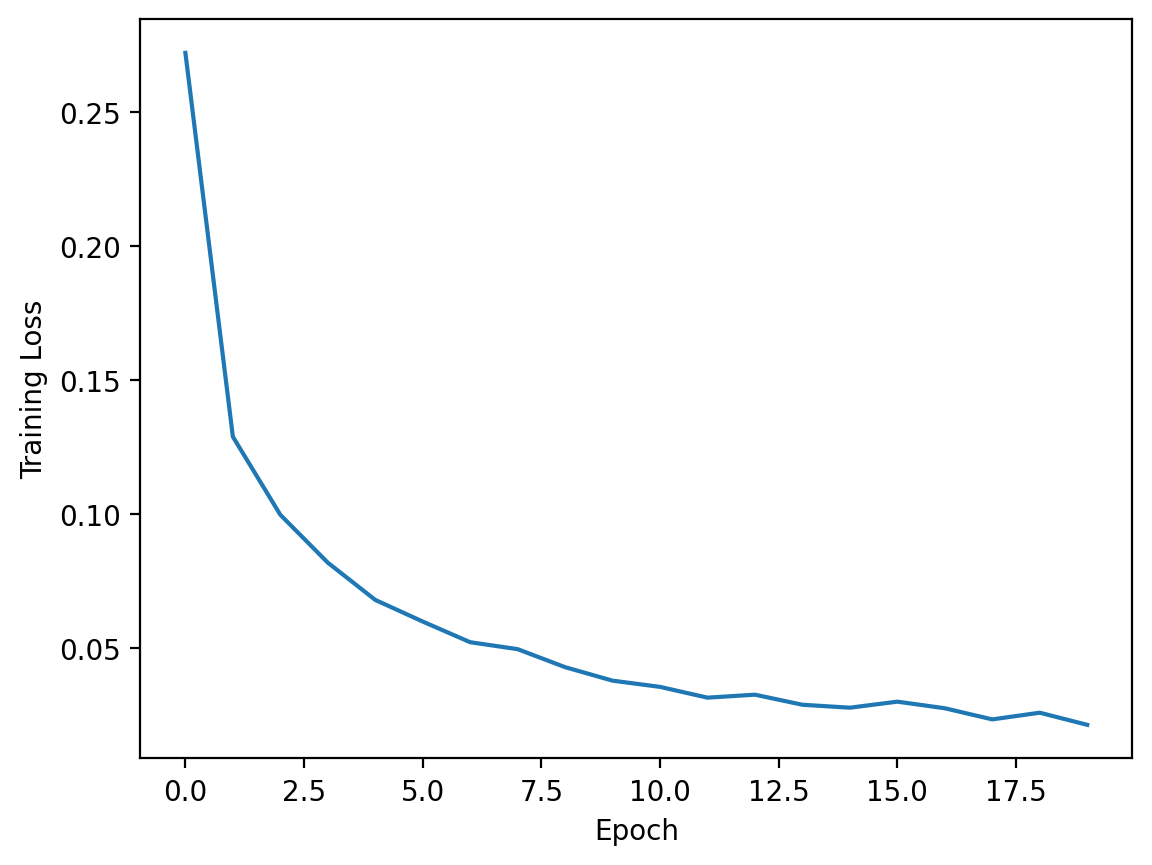

In [180]:
my_MLP = MLP(dimx=img_res[0]*img_res[1],hidden1=1024,hidden2=512,nlabels=10,epochs=20,lr=1e-3)

my_MLP.train(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

plt.plot(my_MLP.loss_during_training)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")

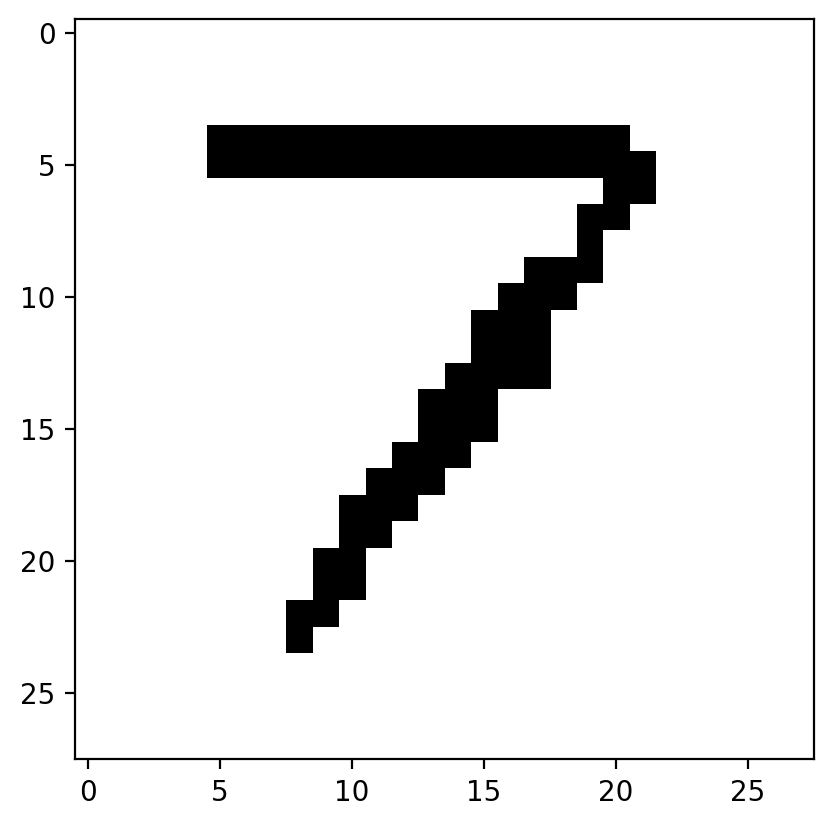

In [178]:
from PIL import Image

# Open the image
img = Image.open("drew7_1.png").convert('F')

# Convert to numpy array (optional)
import numpy as np
img_array = np.array(img)/260
plt.imshow(img_array, cmap='binary')

In [179]:
img_array = img_array.reshape([1, 784])
logprobs = my_MLP.forward(torch.from_numpy(img_array))
top_p, top_class = logprobs.topk(1, dim=1)
print(top_class)
print(logprobs)

tensor([[2]])
tensor([[-14.0192,  -2.1427,  -0.9766,  -1.4473,  -7.8669,  -9.5147, -14.1173,
          -1.7516,  -2.3373,  -8.0754]], grad_fn=<LogSoftmaxBackward0>)


torch.Size([64, 784])
7


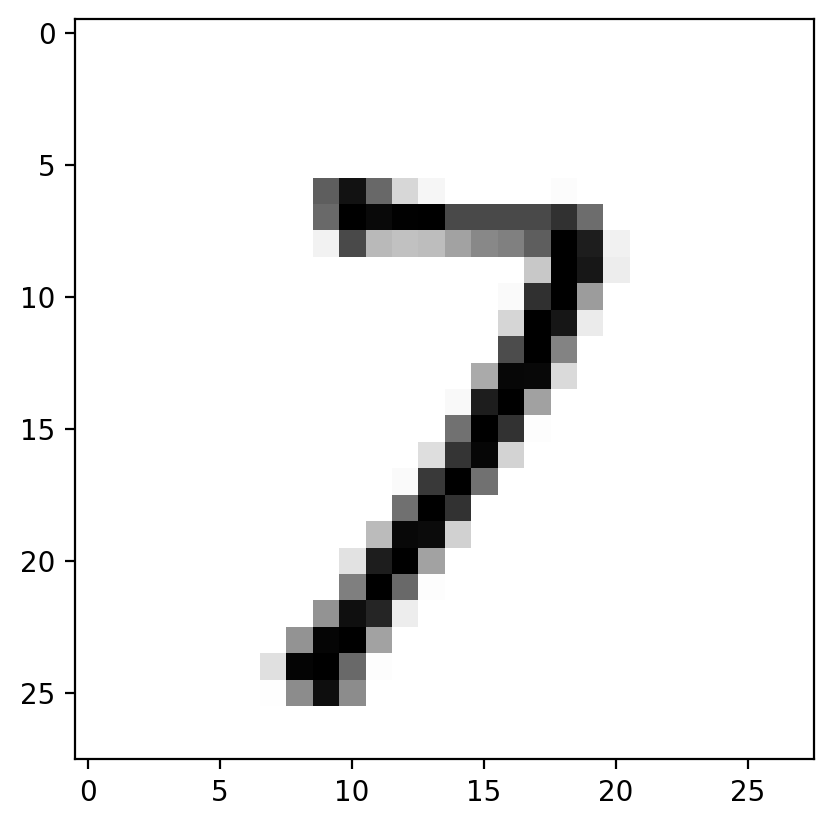

In [149]:
### Check images

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)

logprobs = my_MLP.forward(images.view(images.shape[0], -1))
top_p, top_class = logprobs.topk(1, dim=1)

print(images.view(images.shape[0], -1).shape)

plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())

